# Taha Samavati - 98722134 - Pattern Recognition Project
## PART 3 - TFIDF
### Table of contents:
    3.Tf-iDF representation
      3.0.Preprocessing and stop words removal
      3.1. Gaussian Naive Bayes
        3.1.1. Evaluation : Confusion matrix + ROC
      3.2.SVM
        3.2.1 Evaluation : Confusion matrix + ROC
      3.3.Decision Tree
        3.3.1 Evaluation : Confusion matrix + ROC
      3.4.Random Forest
        3.4.1 Evaluation : Confusion matrix + ROC
      3.5. Performance Comparison of classifiers - TF-iDF

In [0]:
import numpy as np
import nltk
import re
import pandas as pd
import os
import natsort
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix,roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_train_df.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/Pattern_Recognition/cleaned_test_df.csv')

y_train = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_train.npy')
y_test = np.load('/content/gdrive/My Drive/Pattern_Recognition/y_test.npy')

# 3.0.Preprocessing and stop words removal
* Tokenize comments
* Tf-idf doesn't need tokenization, but this tokenization is done in order to be able to remove stop words

In [0]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df_train["tokens"] = df_train["comment"].apply(tokenizer.tokenize)
df_test['tokens'] = df_train['comment'].apply(tokenizer.tokenize)

* Remove stop words
* Add another column to dataframe holding comments with stopwords removed
* tokenized comments now convert back to strings with 'create_string' function

In [0]:
# Load library
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
# Load stop words
stop_words = stopwords.words('english')

def remove_stopwords(listin):
  x=set(listin)
  out = []
  for token in x :
    if token not in stop_words:
      out.append(token)
  return out

# convert tokenized comments back to strings
def create_string(listin):
  st=""
  for i in range(len(listin)):
    st=st+listin[i]+" "
  return st

# remove stop words from test and train data
df_train["comment_strm"] = df_train["tokens"].apply(remove_stopwords).apply(create_string)
df_test['comment_strm'] = df_train['tokens'].apply(remove_stopwords).apply(create_string)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* transform data to tf-idf vectors
* 'comment' column holds comments without stopwords removal
* 'comment_strm' holds comments with stopwords removed

In [0]:
def tfidf(data):
    tfidf_vectorizer=TfidfVectorizer(max_features=16000)
    
    train=tfidf_vectorizer.fit_transform(data)
    
    return train,tfidf_vectorizer

# transform comments without stopwords removal to tf-idf vectors
X_train_tfidf,tfidf_vectorizer=tfidf(df_train['comment'])
X_test_tfidf=tfidf_vectorizer.transform(df_test['comment'])
# transform comments with stopwords removal to tf-idf vectors and hold them in another column of dataframe
X_train_tfidf_st,tfidf_vectorizer_st=tfidf(df_train['comment_strm'])
X_test_tfidf_st=tfidf_vectorizer_st.transform(df_test['comment_strm'])

## 3.1 Gaussian Naive Bayes
* This distribution is used because the input data features are continous
* It is assumed that features have normal distribution

In [0]:
# Create and fit Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb1 = GaussianNB()
gnb.fit(X_train_tfidf.toarray(),y_train)
gnb1.fit(X_train_tfidf_st.toarray(),y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

### 3.1.1 EVALUATION

In [0]:
# Predict and print metrics
y_pred = np.zeros(X_test_tfidf.shape[0],dtype=np.int8)
y_pred_strem = np.zeros(X_test_tfidf_st.shape[0],dtype=np.int8)
for i in range(X_test_tfidf.shape[0]):
    y_pred[i] = gnb.predict(X_test_tfidf[i].toarray())
    y_pred_strem[i] = gnb1.predict(X_test_tfidf_st[i].toarray())

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_strem, average='weighted')
print("Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions=[]
precisions1=[]
precisions.append(precision)
precisions1.append(precision1)

Presicion = 68.85585208825802 % Recall = 67.46 % f1 = 66.84643082057904 %
Presicion = 87.01092290227952 % Recall = 86.764 % f1 = 86.74188671861253 %


In [0]:
def plot_confusion_matrix(y_true,y_predicted, classes, normalize=False, title=None, cmap = plt.cm.Blues):
    if not title:
        if normalize:
            title = "Normalized Confusion matrix"
        else:
            title = "Confusion matrix, Without normalization"
    cm = confusion_matrix(y_true, y_predicted)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[:,np.newaxis]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel="predicted label")
    plt.setp(ax.get_xticklabels(), rotation=45,ha='right', rotation_mode='anchor')
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

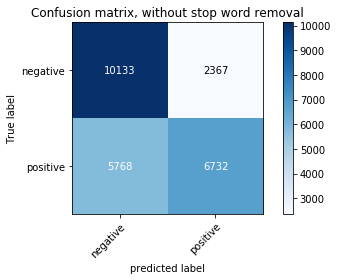

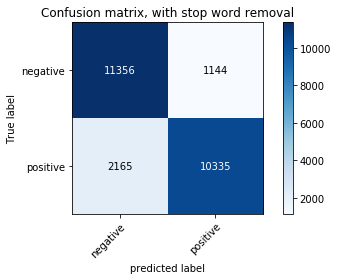

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

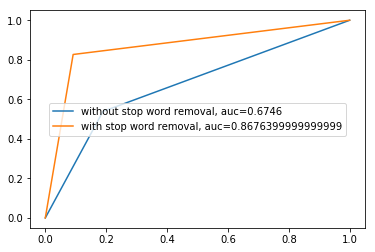

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

## 3.2. SVM Classifier

In [0]:
svmc = LinearSVC(C=0.01)
svmc1 = LinearSVC(C=0.01)
svmc.fit(X_train_tfidf,y_train)
svmc1.fit(X_train_tfidf_st,y_train)

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 3.2.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_svm = np.zeros(X_test_tfidf.shape[0],dtype=np.int8)
y_pred_svm_strem = np.zeros(X_test_tfidf_st.shape[0],dtype=np.int8)
for i in range(X_test_tfidf.shape[0]):
    y_pred_svm[i] = svmc.predict(X_test_tfidf[i].toarray())
    y_pred_svm_strem[i] = svmc1.predict(X_test_tfidf_st[i].toarray())

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_svm_strem, average='weighted')
print("SVM Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Removed stop words Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

SVM Presicion = 85.32784237726099 % Recall = 85.28 % f1 = 85.27501470897987 %
Removed stop words Presicion = 88.52063911705842 % Recall = 88.428 % f1 = 88.42103837627138 %


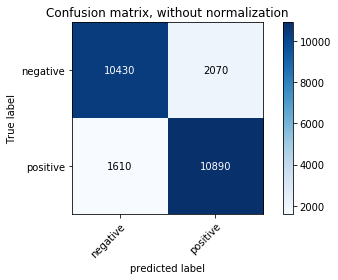

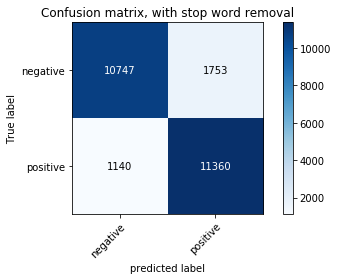

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm, classes=['negative','positive'],
                      title='Confusion matrix, without normalization')

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_svm_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

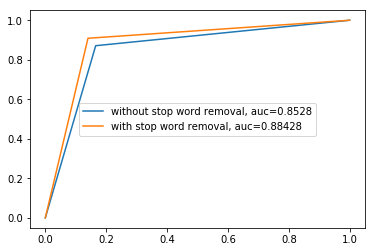

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_svm_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

## 3.3. Decision Tree Classifier

In [0]:
dtc = DTC(random_state=76)
dtc1 = DTC(random_state=76)
dtc.fit(X_train_tfidf,y_train)
dtc1.fit(X_train_tfidf_st,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=76, splitter='best')

### 3.3.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_dtc = np.zeros(X_test_tfidf.shape[0],dtype=np.int8)
y_pred_dtc_strem = np.zeros(X_test_tfidf_st.shape[0],dtype=np.int8)
for i in range(X_test_tfidf.shape[0]):
    y_pred_dtc[i] = dtc.predict(X_test_tfidf[i].toarray())
    y_pred_dtc_strem[i] = dtc1.predict(X_test_tfidf_st[i].toarray())

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_dtc, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_dtc_strem, average='weighted')
print(" Decision Tree Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Removed stop words Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

 Decision Tree Presicion = 69.82007928031712 % Recall = 69.82000000000001 % f1 = 69.81996981996981 %
Removed stop words Presicion = 100.0 % Recall = 100.0 % f1 = 100.0 %


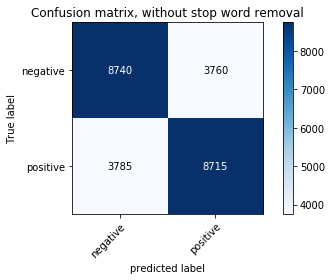

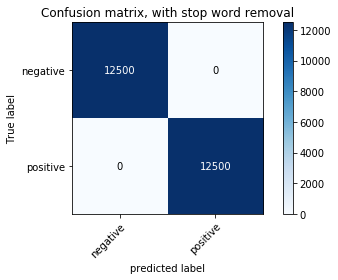

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_dtc_strem, classes=['negative','positive'],
                      title='Confusion matrix, with stop word removal')

plt.show()

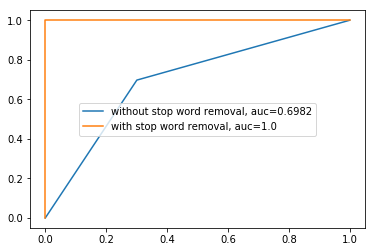

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_dtc)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_dtc_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
#plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
plt.legend(loc=10)
plt.show()

## 3.4 Random Forest classifier

In [0]:
rfc = RandomForestClassifier(n_estimators=20, random_state=42)
rfc1 = RandomForestClassifier(n_estimators=20, random_state=42)
rfc.fit(X_train_tfidf,y_train)
rfc1.fit(X_train_tfidf_st,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### 2.4.1. Evaluation

In [0]:
# Predict and print metrics
y_pred_rfc = np.zeros(X_test_tfidf.shape[0],dtype=np.int8)
y_pred_rfc_strem = np.zeros(X_test_tfidf_st.shape[0],dtype=np.int8)
for i in range(X_test_tfidf.shape[0]):
    y_pred_rfc[i] = rfc.predict(X_test_tfidf[i].toarray())
    y_pred_rfc_strem[i] = rfc1.predict(X_test_tfidf_st[i].toarray())

precision,recall,fscore,_ = precision_recall_fscore_support(y_test, y_pred_rfc, average='weighted')
precision1,recall1,fscore1,_ = precision_recall_fscore_support(y_test, y_pred_rfc_strem, average='weighted')
print("Random Forest Presicion = "+str(precision*100)+" % Recall = "+str(recall*100)+" % f1 = "+str(fscore*100)+" %")
print("Removed stopwords Presicion = "+str(precision1*100)+" % Recall = "+str(recall1*100)+" % f1 = "+str(fscore1*100)+" %")
precisions.append(precision)
precisions1.append(precision1)

Random Forest Presicion = 78.65072652041594 % Recall = 78.388 % f1 = 78.33834076751482 %
Removed stopwords Presicion = 99.92803195394046 % Recall = 99.928 % f1 = 99.92799998848001 %


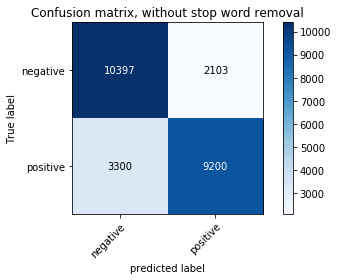

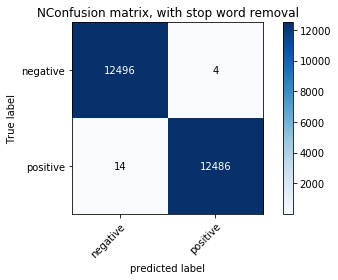

In [0]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc, classes=['negative','positive'],
                      title='Confusion matrix, without stop word removal')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred_rfc_strem, classes=['negative','positive'],
                      title='NConfusion matrix, with stop word removal')

plt.show()

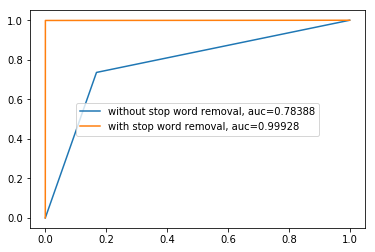

In [0]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rfc)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test, y_pred_rfc_strem)
roc_auc1 = auc(fpr1, tpr1)
plt.figure()
plt.plot(fpr,tpr,label="without stop word removal, auc="+str(roc_auc))
plt.plot(fpr1,tpr1,label="with stop word removal, auc="+str(roc_auc1))
plt.legend(loc=10)
plt.show()

# 3.5 Comparison  - TF-IDF method

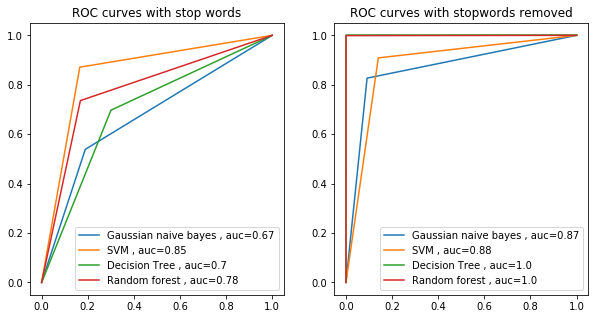

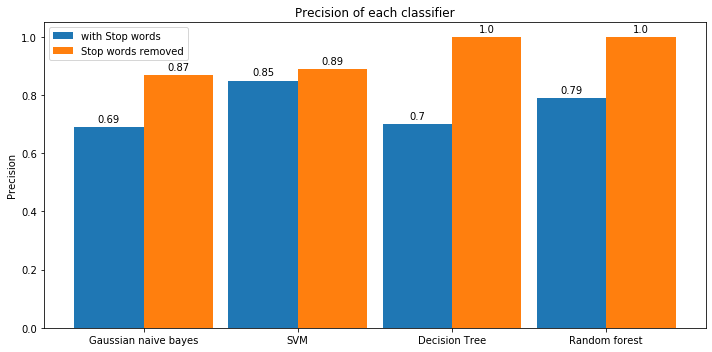

In [0]:
def autolabel(rects):
    """Attach a text label above each bar """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Compare ROC and AUC among different classifiers
y_preds = [y_pred, y_pred_svm, y_pred_dtc, y_pred_rfc]
y_preds_st = [y_pred_strem, y_pred_svm_strem, y_pred_dtc_strem, y_pred_rfc_strem]
clsf_names=['Gaussian naive bayes','SVM','Decision Tree','Random forest']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(len(y_preds)):

  fpr, tpr, _ = roc_curve(y_test, y_preds[i])
  roc_auc = auc(fpr, tpr)
  ax[0].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[0].legend(loc=4)
ax[0].set_title('ROC curves with stop words')

for i in range(len(y_preds_st)):

  fpr, tpr, _ = roc_curve(y_test, y_preds_st[i])
  roc_auc = auc(fpr, tpr)
  ax[1].plot(fpr,tpr,label=clsf_names[i]+" , auc="+str(round(roc_auc,2)))
  
ax[1].legend(loc=4)
ax[1].set_title('ROC curves with stopwords removed')

plt.show()

fig, ax = plt.subplots(figsize=(10,5))
labels = clsf_names
data = np.round(precisions,2)
data_stp_rem = np.round(precisions1,2)

x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars


rects1 = ax.bar(x - width/2, data, width, label="with Stop words")
rects2 = ax.bar(x + width/2, data_stp_rem, width, label="Stop words removed")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Precision')
ax.set_title('Precision of each classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


* From figures above The performance of classifiers significantly increased after removing stopwords
* But the SVM performance slightly increased from 0.85 to 0.89
* Before removing stop words the best classifier was SVM
* After removing stop words best classifiers are DT and Random forest
* Concolusion : removing stop words is necessary when using tf-idf method